In [ ]:
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
files = zf.ZipFile("/content/drive/MyDrive/M4/trashnet-data/datasettrash.zip",'r')
files.extractall()
files.close()
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['trash', 'glass', 'metal', 'cardboard', 'paper', 'plastic', '.DS_Store']

In [ ]:
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.7*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

In [ ]:
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "data/test/"+waste_type
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files, test_dest)

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers import Dropout
from keras.applications import DenseNet201, DenseNet121
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.metrics import  classification_report

In [ ]:
base_model=DenseNet201(weights='imagenet',include_top=False,
                     input_shape=(224, 224, 3)) 

In [ ]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.5)(x)
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
x=Dropout(0.2)(x)
preds=Dense(6,activation='softmax')(x) #final layer with softmax activation
model=Model(inputs=base_model.input,outputs=preds)

In [ ]:
len(model.layers)

715

In [ ]:
for layer in model.layers[:140]:
    layer.trainable=False
for layer in model.layers[140:]:
    layer.trainable=True

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   fill_mode='nearest',
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2) # Your Code Here

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
from imutils import paths
train_dir = 'data/train'
validation_dir = 'data/valid/'
test_dir = 'data/test/'
totalTrain = len(list(paths.list_images(train_dir)))
totalVal = len(list(paths.list_images(validation_dir)))
totalTest = len(list(paths.list_images(test_dir)))
print("Total Training: ", totalTrain)
print("Total Validation: ",totalVal)
print("Total test: ", totalTest)

Total Training:  1766
Total Validation:  378
Total test:  383


In [ ]:
BATCH_SIZE = 16
TARGET_SIZE = (224, 224)

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                   target_size=TARGET_SIZE)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                   batch_size=BATCH_SIZE,
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   shuffle=False,
                                                   target_size=TARGET_SIZE)

# initilaize the testing generator
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    class_mode="categorical",
    color_mode='rgb',
    target_size=TARGET_SIZE,  
    shuffle=False, 
    batch_size=BATCH_SIZE)

Found 1766 images belonging to 6 classes.
Found 378 images belonging to 6 classes.
Found 383 images belonging to 6 classes.


In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=opt,
             metrics=['accuracy'])

[INFO] compiling model...


In [ ]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this willl allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] trainning head...")
H = model.fit_generator( 
    train_generator,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=totalVal // BATCH_SIZE,
    epochs=20)

[INFO] trainning head...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
110/110 [==============================] - 1228s 11s/step - loss: 1.9113 - accuracy: 0.1786 - val_loss: 1.5585 - val_accuracy: 0.4239
Epoch 2/20
110/110 [==============================] - 1206s 11s/step - loss: 1.7379 - accuracy: 0.2801 - val_loss: 1.4138 - val_accuracy: 0.5571
Epoch 3/20
110/110 [==============================] - 1210s 11s/step - loss: 1.6274 - accuracy: 0.3221 - val_loss: 1.2589 - val_accuracy: 0.6277
Epoch 4/20
110/110 [==============================] - 1214s 11s/step - loss: 1.4421 - accuracy: 0.4425 - val_loss: 1.0835 - val_accuracy: 0.6984
Epoch 5/20
110/110 [==============================] - 1219s 11s/step - loss: 1.2955 - accuracy: 0.5138 - val_loss: 0.9078 - val_accuracy: 0.7337
Epoch 6/20
110/110 [==============================] - 1215s 11s/step - loss: 1.1247 - accuracy: 0.5889 - val_loss: 0.7644 - val_accuracy: 0.7582
Epoch 7/20
110/110 [==============================] - 1214s 11s/step - loss: 0.9693 - accuracy: 0.6494 - val_loss: 0.6584 - val_ac

<Figure size 432x288 with 0 Axes>

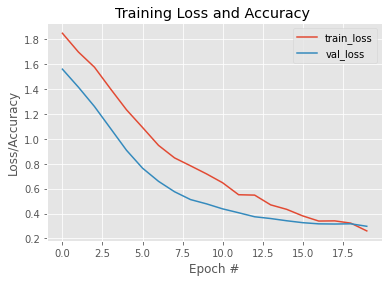

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the training loss and accuracy

plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy ")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.figure()
#plt.plot(N, H.history["acc"], label="train_acc")
#plt.plot(N, H.history["val_acc"], label="val_acc")
#plt.title("Training Loss and Accuracy on CIFAR-10")
#plt.xlabel("Epoch #")
#plt.ylabel("Loss/Accuracy")
#plt.legend()

In [ ]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
test_generator.reset()
predIdxs = model.predict_generator(test_generator, 
     steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs, 
     target_names=test_generator.class_indices.keys()))
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
# plot_training(H, 50, config.WARMUP_PLOT_PATH)

print('Confusion Matrix')
cm = metrics.confusion_matrix(test_generator.classes, predIdxs)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_generator.classes, predIdxs))

[INFO] evaluating after fine-tuning network head...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

   cardboard       1.00      0.92      0.96        61
       glass       0.94      0.95      0.94        76
       metal       0.94      0.95      0.94        62
       paper       0.90      0.94      0.92        90
     plastic       0.93      0.90      0.92        73
       trash       0.73      0.76      0.74        21

    accuracy                           0.92       383
   macro avg       0.91      0.90      0.90       383
weighted avg       0.93      0.92      0.92       383

Confusion Matrix
[[56  0  0  4  0  1]
 [ 0 72  3  0  1  0]
 [ 0  2 59  0  1  0]
 [ 0  0  0 85  1  4]
 [ 0  3  0  3 66  1]
 [ 0  0  1  2  2 16]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        61
           1       0.94      0.95      0.94        76
           2       0.94      0.95      0.94        62
           3       0.90      0.94      0.92        90
           4       0

In [ ]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save('DenseNet121.h5')

[INFO] serializing network...


In [ ]:
# import the necessary packages
from keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
%matplotlib inline

In [ ]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('DenseNet121.h5')

[INFO] loading model...


In [ ]:
from keras.applications.mobilenet import decode_predictions, preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import imutils
import cv2
%matplotlib inline

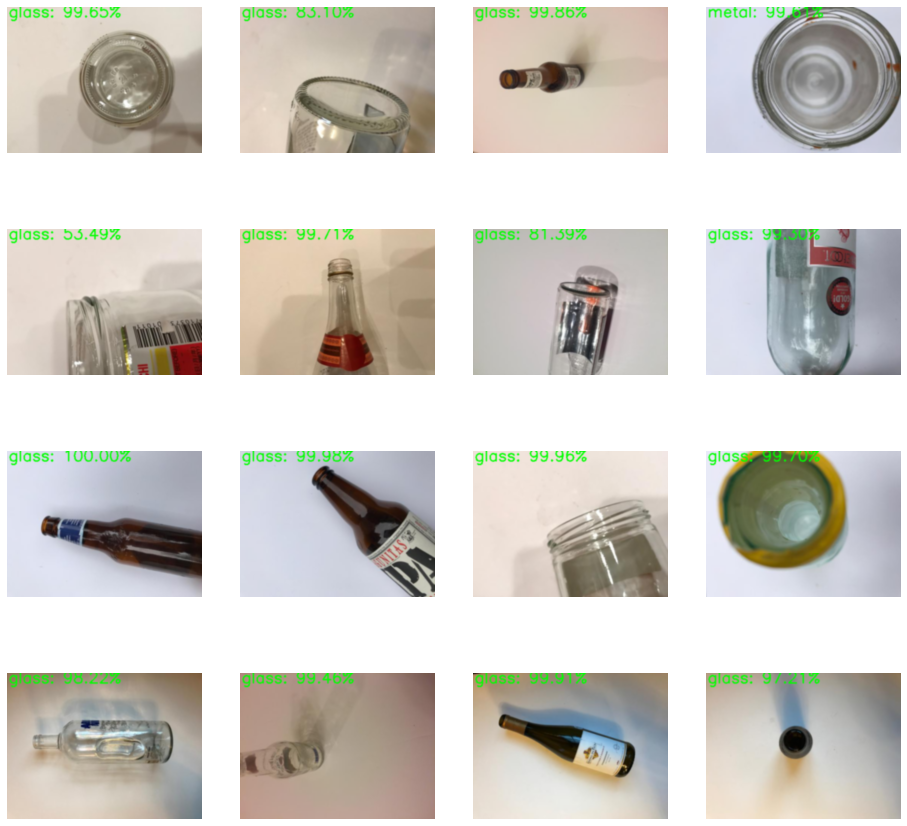

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 8
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# pic_index += 8

# load the input image and then clone it so we can draw on it later
waste_types = ['cardboard','glass','metal','paper','plastic','trash']
test_d = 'data/test/' + waste_types[1] + '/'
# test_d = 'mytest/'
test_files = os.listdir(test_d)[0:16]
for i, fn in enumerate(test_files):
    
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1, facecolor='red')
    sp.axis('Off') # Don't show axes (or gridlines)
    # predicting images
    path = test_d + fn
    image = cv2.imread(path)

    img = load_img(path, target_size=TARGET_SIZE)

    output = image.copy()
    output = imutils.resize(output, width=400)

    img = img_to_array(img)
    
    # our model was trained on RGB ordered images but OpenCV represents
    # images in BGR order, so swap the channels, and then resize to
    # 224x224 (the input dimensions for VGG16)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    # print(image.shape)
    
    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32") / 255.
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # pass the image through the network to obtain our predictions
    # preds = model.predict(np.expand_dims(image / 255., axis=0))[0]
    preds = model.predict(img)[0]
    i = np.argmax(preds)
    label = waste_types[i]
    # print(label)
    
    # draw the prediction on the output image
    text = "{}: {:.2f}%".format(label, preds[i] * 100)
    cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 1.05,
        (0, 255, 0), 2)
    
    # show the output image
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), interpolation = 'bicubic')
    # cv2.imshow("Output", output)
    # cv2.waitKey(0)
plt.show()

In [ ]:
from keras.applications.vgg16 import VGG16

base_model_2 = VGG16(weights='imagenet',include_top=False,
                     input_shape=(224, 224, 3)) 

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model_2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
x=base_model_2.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.5)(x)
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
x=Dropout(0.2)(x)
preds=Dense(6,activation='softmax')(x) #final layer with softmax activation
model=Model(inputs=base_model_2.input,outputs=preds)

In [ ]:
len(model.layers)

27

In [ ]:
for layer in model.layers[:11]:
    layer.trainable=False
for layer in model.layers[11:]:
    layer.trainable=True

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=opt,
             metrics=['accuracy'])

[INFO] compiling model...


In [ ]:
print("[INFO] trainning head...")
H = model.fit_generator( 
    train_generator,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=totalVal // BATCH_SIZE,
    epochs=5)

[INFO] trainning head...
Epoch 1/5
110/110 [==============================] - 1874s 17s/step - loss: 1.7885 - accuracy: 0.2103 - val_loss: 1.5358 - val_accuracy: 0.4266
Epoch 2/5
110/110 [==============================] - 1873s 17s/step - loss: 1.5262 - accuracy: 0.3703 - val_loss: 1.1147 - val_accuracy: 0.5951
Epoch 3/5
110/110 [==============================] - 1867s 17s/step - loss: 1.2929 - accuracy: 0.4680 - val_loss: 0.9153 - val_accuracy: 0.6875
Epoch 4/5
110/110 [==============================] - 1868s 17s/step - loss: 1.1248 - accuracy: 0.5537 - val_loss: 0.8183 - val_accuracy: 0.6576
Epoch 5/5
110/110 [==============================] - 1869s 17s/step - loss: 1.0052 - accuracy: 0.5971 - val_loss: 0.7533 - val_accuracy: 0.7255


<Figure size 432x288 with 0 Axes>

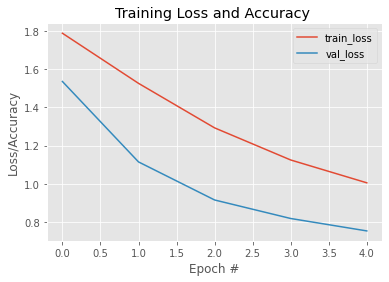

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the training loss and accuracy

plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy ")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.figure()
#plt.plot(N, H.history["acc"], label="train_acc")
#plt.plot(N, H.history["val_acc"], label="val_acc")
#plt.title("Training Loss and Accuracy on CIFAR-10")
#plt.xlabel("Epoch #")
#plt.ylabel("Loss/Accuracy")
#plt.legend()

In [ ]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
test_generator.reset()
predIdxs = model.predict_generator(test_generator, 
     steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs, 
     target_names=test_generator.class_indices.keys()))
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
# plot_training(H, 50, config.WARMUP_PLOT_PATH)

print('Confusion Matrix')
cm = metrics.confusion_matrix(test_generator.classes, predIdxs)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_generator.classes, predIdxs))

[INFO] evaluating after fine-tuning network head...
              precision    recall  f1-score   support

   cardboard       0.95      0.87      0.91        61
       glass       0.69      0.46      0.55        76
       metal       0.62      0.76      0.68        62
       paper       0.66      0.97      0.79        90
     plastic       0.62      0.59      0.61        73
       trash       0.00      0.00      0.00        21

    accuracy                           0.69       383
   macro avg       0.59      0.61      0.59       383
weighted avg       0.66      0.69      0.66       383

Confusion Matrix
[[53  0  1  7  0  0]
 [ 0 35 20  2 19  0]
 [ 0  3 47 10  2  0]
 [ 3  0  0 87  0  0]
 [ 0 12  8 10 43  0]
 [ 0  1  0 15  5  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        61
           1       0.69      0.46      0.55        76
           2       0.62      0.76      0.68        62
           3       0.6

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


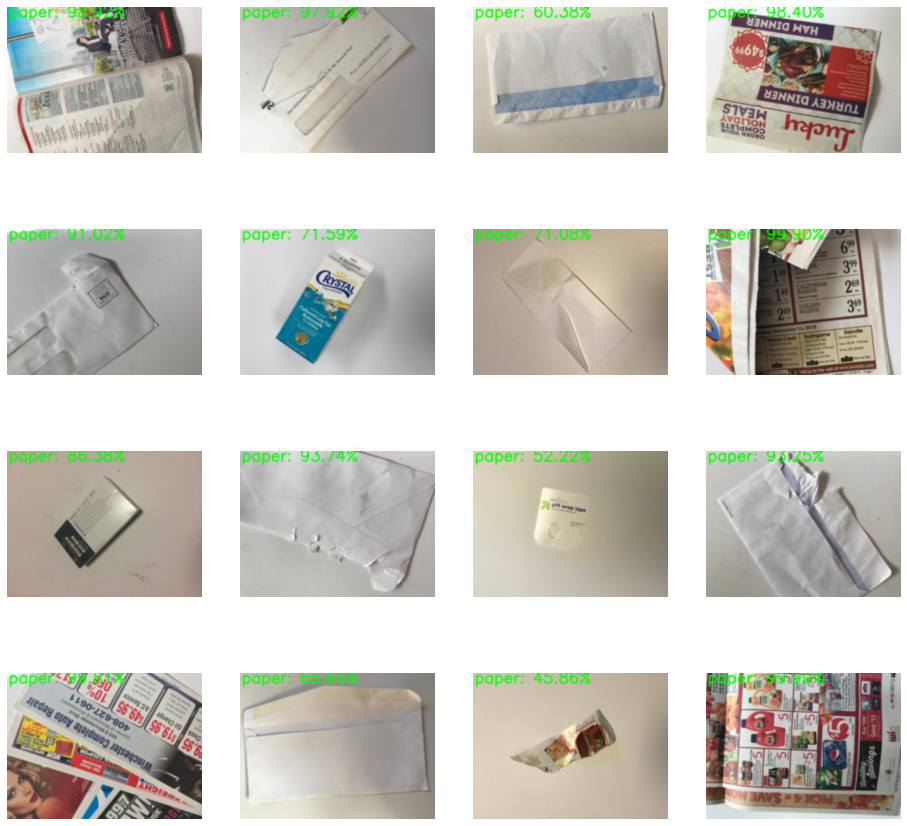

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 8
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# pic_index += 8

# load the input image and then clone it so we can draw on it later
waste_types = ['cardboard','glass','metal','paper','plastic','trash']
test_d = 'data/test/' + waste_types[3] + '/'
# test_d = 'mytest/'
test_files = os.listdir(test_d)[0:16]
for i, fn in enumerate(test_files):
    
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1, facecolor='red')
    sp.axis('Off') # Don't show axes (or gridlines)
    # predicting images
    path = test_d + fn
    image = cv2.imread(path)

    img = load_img(path, target_size=TARGET_SIZE)

    output = image.copy()
    output = imutils.resize(output, width=400)

    img = img_to_array(img)
    
    # our model was trained on RGB ordered images but OpenCV represents
    # images in BGR order, so swap the channels, and then resize to
    # 224x224 (the input dimensions for VGG16)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    # print(image.shape)
    
    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32") / 255.
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # pass the image through the network to obtain our predictions
    # preds = model.predict(np.expand_dims(image / 255., axis=0))[0]
    preds = model.predict(img)[0]
    i = np.argmax(preds)
    label = waste_types[i]
    # print(label)
    
    # draw the prediction on the output image
    text = "{}: {:.2f}%".format(label, preds[i] * 100)
    cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 1.05,
        (0, 255, 0), 2)
    
    # show the output image
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), interpolation = 'bicubic')
    # cv2.imshow("Output", output)
    # cv2.waitKey(0)
plt.show()

In [ ]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save('VGG16.h5')

[INFO] serializing network...


In [ ]:
# Testing on real life objects
#instead of path any image path placed in the files can be added

path =  '/content/metal.jpeg'
image = cv2.imread(path)

img = load_img(path, target_size=TARGET_SIZE)

output = image.copy()
output = imutils.resize(output, width=400)

img = img_to_array(img)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, TARGET_SIZE)

image = image.astype("float32") / 255.
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

preds = model.predict(img)[0]
i = np.argmax(preds)
label = waste_types[i]

text = "{}: {:.2f}%".format(label, preds[i] * 100)
cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 1.05,
      (0, 255, 0), 2)
    
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), interpolation = 'bicubic')

plt.show()